# **Predicting the Band Gap of Metal Oxides - a ML Study**

In [2]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


### **Querying**: filter for oxygen-containing compounds. To filter for metals, I would have to manually enter every metal in an "or" list, but it is much easier to do this filtering with Pymatgen. Also, I want to filter for materials with non-zero band gaps, but the band gap filter function for the API does not work, I have tried multiple times, but it always returns nothing. I again do this step later with Pymatgen

### **Warning**: This query of 10,000 materials took about 1hr 15 mins to run. The total notebook takes my computer about 2 hr 30 mins to run

In [3]:
import requests
url = "http://oqmd.org/oqmdapi/formationenergy"

all_entries = []
limit = 50  # max entries per request allowed by OQMD
offset = 0
max_entries = 10000

while len(all_entries) < max_entries:
    params = {
        "filter": "element_set=(O)",
        "limit": limit,
        "offset": offset
    }

    r = requests.get(url, params=params)
    data = r.json()

    batch = data.get("data", [])
    if not batch:
        break

    all_entries.extend(batch)
    offset += limit

    if len(all_entries) >= max_entries:
        # Stop if we have enough data
        all_entries = all_entries[:max_entries]
        break

print(f"Total entries retrieved: {len(all_entries)}")

#for entry in all_entries[:10000]:  # print entries
#    print(entry.get("name"))

#for entry in all_entries[:10]:  # print first 10 as example
#    print(entry.get("volume"), entry.get("band_gap"))

Total entries retrieved: 10000


In [4]:
# CHECK COMPOSITION TO SEE IF IT CONTAINS OXYGEN
for entry in all_entries[:100]:  # print first 100 entries
    print(entry.get("name"), entry.get("band_gap"))

ZnO 0.0
CuO 0.0
TiO 0.0
VO 1.191
BeO 7.021
MgO 4.975
MnO 0.423
NiO 2.62
ZnO 0.967
AgO 0.0
NiO 2.61
FeO 0.0
ZnO 1.084
AlO 0.0
NiO 2.611
CaO 3.687
PdO 0.0
SrO 2.792
SrO 3.363
PaO 0.0
BaO 2.111
TaO 0.0
O 0.0
ScO 0.0
YbO 3.583
BeO 8.496
CdO 0.0
NbO 0.0
NpO 0.0
PdO 0.0
GdO 0.0
PuO 0.0
NiO 2.627
BiO 0.0
ZrO 0.0
PtO 0.0
FeO 1.259
UO 0.0
SnO2 0.622999999999999
O 0.0
PrO 0.0
SmO 0.0
ZrO2 3.344
CrO 0.0
PdO 0.0
K2O 1.942
SrO2 3.152
Li2O 5.091
O 0.0
UO2 0.0
BaO2 2.349
Na2O 2.219
PuO2 0.0
LiO2 0.0
PaO2 0.0
Al2O 0.0
SiO2 2.245
TbO2 0.0
BaO2 1.994
Ag2O 0.0
Rb2O 1.637
HgO 0.0
CSO 4.762
KO2 0.0
RbO2 0.0
Cs2O 1.251
NpO2 2.612
PtO2 1.415
CsO2 0.0
NiO2 1.249
PbO2 0.0
CsO 1.902
NaCuO2 0.749
LiO3 0.0
AlCuO2 2.332
RbNdO2 3.697
GaCuO2 1.336
RbSmO2 3.774
FeCuO2 1.003
RbGdO2 3.755
YbAgO2 0.0
LiNiO2 0.0
PbO 1.276
NaNiO2 0.43
NaFeO2 1.679
NaCuO2 0.873
KPrO2 3.737
RbDyO2 3.704
RbHoO2 3.854
ReO3 0.0
NaNO2 2.453
RbEuO2 0.0
PtO 0.0
UO3 2.536
RbLaO2 3.691
CrCuO2 1.787
CaO 3.481
CdO 0.218
FeAgO2 1.089
CuO 0.0


In [5]:
#EXPORT TO PANDAS DATAFRAME
import pandas as pd

#records = data["all_entries"]
df = pd.DataFrame(all_entries)

### Use Pymatgen to further filter for metal-containing compounds and band_gap that is non-zero

In [6]:
# FILTER FOR METAL OXIDES + NON-ZERO BANDGAP
from pymatgen.core import Composition
from pymatgen.core.periodic_table import Element
import pandas as pd

def has_metal_and_oxygen(formula):
    comp = Composition(formula)

    # Must contain oxygen
    if Element("O") not in comp:
        return False

    # Check if any other element is a metal
    for el in comp.elements:
        if el.symbol != "O" and Element(el).is_metal:
            return True

    return False

# --- Apply both filters ---
df_oxides = df[
    df["composition"].apply(has_metal_and_oxygen) &
    (df["band_gap"] > 0)   # NEW: filter for non-zero band gap
].reset_index(drop=True)

print("Number of metal oxides with non-zero band gaps:", len(df_oxides))



Number of metal oxides with non-zero band gaps: 3601


### Data-cleaning: check and remove NaN bandgap entries. I checked, there are not duplicate entries

In [21]:
# Drop rows where band_gap is NaN
df_oxides = df_oxides.dropna(subset=["band_gap"])

# Drop duplicate compositions, keep first occurrence
df_oxides = df_oxides.drop_duplicates(subset=["composition"])

# Reset index after cleaning
df_oxides = df_oxides.reset_index(drop=True)

print("Cleaned dataframe size after dropping NaNs and duplicate compositions:", len(df_oxides))


Cleaned dataframe size after dropping NaNs and duplicate compositions: 2835


### Dataset statistics

In [22]:
import pandas as pd
import numpy as np
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core import Structure

print("DATASET STATISTICS\n")

df1 = df_oxides.copy()

# BASIC STATS
print("BASIC INFO")
print(f"Total entries: {len(df1)}")
print(f"Unique compositions: {df1['composition'].nunique()}")
print(f"Unique spacegroup symbols: {df1['spacegroup'].nunique()}")
print()

# BAND GAP STATS
print("BAND GAP STATISTICS")
print(df1["band_gap"].describe())
print()

# SPACEGROUP SYMBOL DISTRIBUTION
print("SPACEGROUP DISTRIBUTION (SYMBOLS)")
print(df1["spacegroup"].value_counts().head(20))
print()

# STRUCTURE / ATOMS / VOLUME STATS
print("ATOM & VOLUME STATISTICS")
if "natoms" in df1.columns:
    print(df1["natoms"].describe())
if "volume" in df1.columns:
    print(df1["volume"].describe())
print()

# STRUCTURE PRESENCE
def has_structure(x):
    return x is not None and str(x) != "None"

structure_fraction = df1["sites"].apply(has_structure).mean()

print("STRUCTURE AVAILABILITY")
print(f"Entries with structure data: {structure_fraction*100:.2f}%")
print()

# SUMMARY TABLE
summary = {
    "Total entries": len(df1),
    "Unique compositions": df1["composition"].nunique(),
    "Average band gap (eV)": df1["band_gap"].mean(),
    "Median band gap (eV)": df1["band_gap"].median(),
    "Fraction with structure (%)": structure_fraction * 100,
}

print("SUMMARY TABLE")
for k, v in summary.items():
    print(f"{k}: {v}")


DATASET STATISTICS

BASIC INFO
Total entries: 2835
Unique compositions: 2835
Unique spacegroup symbols: 141

BAND GAP STATISTICS
count    2835.000000
mean        2.786638
std         1.518161
min         0.183000
25%         1.596000
50%         2.651000
75%         3.826000
max         7.769000
Name: band_gap, dtype: float64

SPACEGROUP DISTRIBUTION (SYMBOLS)
spacegroup
Pm-3m      378
C2/m       214
P-1        212
C2/c       162
R-3m       108
I4/mmm     101
P4/nmm     101
Cmcm        93
P21/c       84
P-3m1       79
Fm-3m       78
P4/mmm      74
I41/amd     65
P21/m       61
R-3         58
Pnma        47
P1          43
C2          40
Fd-3m       34
P2/c        31
Name: count, dtype: int64

ATOM & VOLUME STATISTICS
count    2835.000000
mean       14.500529
std        10.886771
min         2.000000
25%         8.000000
50%        12.000000
75%        18.000000
max       175.000000
Name: natoms, dtype: float64
count    2835.000000
mean      190.248488
std       120.215884
min        13.

=== DATASET STATISTICS ===
Total data points: 2835
Unique compositions: 2835
Unique prototypes: 542
Crystal system categories: 8

=== CRYSTAL SYSTEM RELATIVE DISTRIBUTION (%) ===
crystal_system
Cubic           18.91
Monoclinic      17.81
Tetragonal      17.60
Orthorhombic    14.32
Trigonal        13.72
Triclinic        8.99
Unknown          6.31
Hexagonal        2.33
Name: proportion, dtype: float64



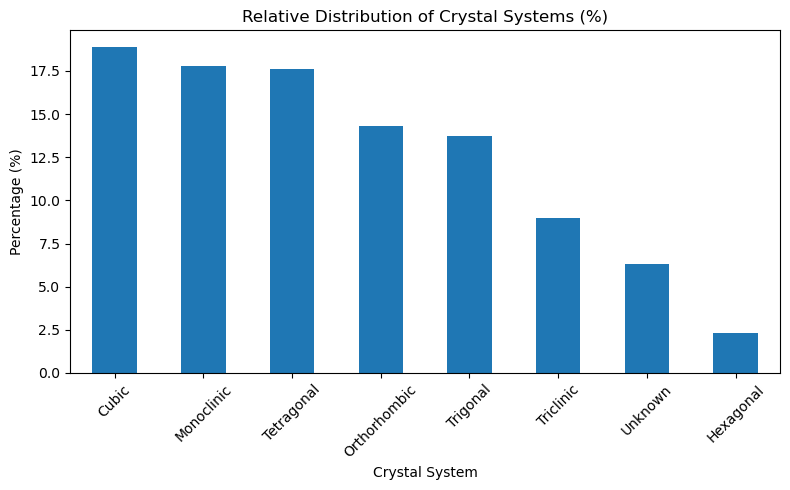

In [23]:
from pymatgen.symmetry.groups import SpaceGroup
import matplotlib.pyplot as plt

df1 = df_oxides.copy()

# --- CLEAN SPACEGROUP COLUMN (still needed to extract crystal system) ---
def normalize_spacegroup(x):
    """Convert spacegroup entries into valid SpaceGroup objects."""
    if pd.isna(x):
        return None

    # Integer format
    if isinstance(x, int):
        try:
            return SpaceGroup.from_int_number(x)
        except:
            return None

    # Numeric string
    if isinstance(x, str) and x.isdigit():
        try:
            return SpaceGroup.from_int_number(int(x))
        except:
            return None

    # Hermann–Mauguin format
    if isinstance(x, str):
        try:
            return SpaceGroup(x)
        except:
            return None

    return None

df1["sg_obj"] = df1["spacegroup"].apply(normalize_spacegroup)

# --- Extract crystal system (cleaned, simplified) ---
def get_crystal_system(sg_obj):
    if sg_obj is None:
        return "Unknown"
    try:
        return sg_obj.crystal_system.capitalize()
    except:
        return "Unknown"

df1["crystal_system"] = df1["sg_obj"].apply(get_crystal_system)

# === PRINT DATASET STATISTICS (no spacegroup info) ===
print("=== DATASET STATISTICS ===")
print(f"Total data points: {len(df1)}")
print(f"Unique compositions: {df1['composition'].nunique()}")
print(f"Unique prototypes: {df1['prototype'].nunique()}")
print(f"Crystal system categories: {df1['crystal_system'].nunique()}")
print()

print("=== CRYSTAL SYSTEM RELATIVE DISTRIBUTION (%) ===")
rel_dist = (df1["crystal_system"].value_counts(normalize=True) * 100).round(2)
print(rel_dist)
print()

# === PLOTTING RELATIVE % DISTRIBUTION ===
plt.figure(figsize=(8,5))
rel_dist.plot(kind="bar")
plt.title("Relative Distribution of Crystal Systems (%)")
plt.xlabel("Crystal System")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Now I have a dataset of compounds that contain oxygen and 1 or more metal ions - **Metal Oxides!**

In [24]:
df_oxides.head()

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,volume,ntypes,natoms,unit_cell,sites,band_gap,delta_e,stability,fit,calculation_label
0,VO,5578,5023,28681.0,4061871,5578.0,O1 V1,AB,NaCl,Fm-3m,21.6233,2,2,"[[2.211215, -2.211215, 0.0], [-2.211215, 0.0, ...","[O @ 0.5 0 0.5, V @ 0 0 0]",1.191,-2.259973,0.002871,standard,static
1,BeO,20737,5038,163820.0,4061895,20737.0,Be1 O1,AB,ZnS(cF8),F-43m,13.7009,2,2,"[[1.899211, -1.899211, 0.0], [-1.899211, 0.0, ...","[Be @ 0 0 0, O @ 0.75 0.5 0.25]",7.021,-2.960379,0.005831,standard,static
2,MgO,2577,5281,9863.0,4062087,2577.0,Mg1 O1,AB,NaCl,Fm-3m,18.5095,2,2,"[[2.099529, -2.099529, 0.0], [-2.099529, 0.0, ...","[Mg @ 0 0 0, O @ 0.5 0 0.5]",4.975,-2.945943,0.000346,standard,static
3,MnO,2578,5284,9864.0,4062090,2578.0,Mn1 O1,AB,NaCl,Fm-3m,22.1982,2,2,"[[2.230638, -2.230638, 0.0], [-2.230638, 0.0, ...","[Mn @ 0 0 0, O @ 0.5 0 0.5]",0.423,-2.036127,0.002118,standard,static
4,NiO,2580,5289,9866.0,4062093,8206.0,Ni1 O1,AB,NaCl,Fm-3m,18.1016,2,2,"[[2.083992, -2.083992, 0.0], [-2.083992, 0.0, ...","[Ni @ 0 0 0, O @ 0.5 0 0.5]",2.620,-1.239372,0.002141,standard,static


In [25]:
df_oxides.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,2835.000000,2.835000e+03,2469.000000,2.835000e+03,2834.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,55959.944621,5.279984e+05,121850.262454,4.330324e+06,59235.855328,190.248488,3.499471,14.500529,2.786638,-2.221272,0.110539
std,113227.655473,4.549565e+05,125565.627333,2.755716e+05,120341.665443,120.215884,0.733017,10.886771,1.518161,0.747234,1.044998
min,1605.000000,5.023000e+03,7.000000,4.061871e+06,1605.000000,13.700900,2.000000,2.000000,0.183000,-4.150927,0.000000
25%,6332.000000,1.450695e+05,30283.000000,4.090164e+06,6482.250000,109.740500,3.000000,8.000000,1.596000,-2.798503,0.000000
50%,15461.000000,4.811750e+05,75254.000000,4.225941e+06,15693.000000,165.406000,3.000000,12.000000,2.651000,-2.260385,0.004057
75%,23758.500000,8.489845e+05,167053.000000,4.504952e+06,23924.000000,243.377000,4.000000,18.000000,3.826000,-1.659173,0.044370
max,675524.000000,1.234533e+06,653737.000000,4.790301e+06,675524.000000,1623.180000,7.000000,175.000000,7.769000,0.224984,54.471736


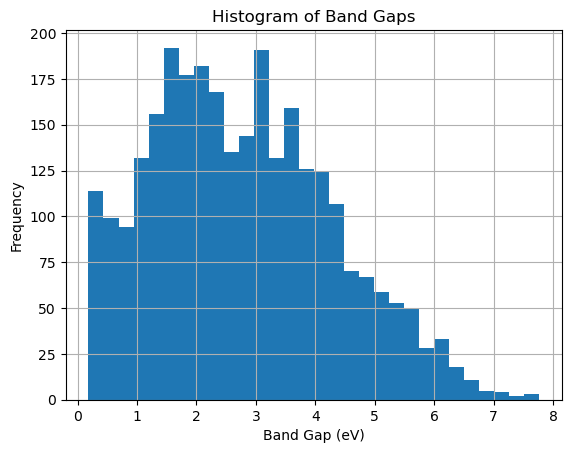

In [26]:
import matplotlib.pyplot as plt

df_oxides['band_gap'].hist(bins=30)
plt.xlabel('Band Gap (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Band Gaps')
plt.show()

### **Featurization**: OQMD uses strings to identify compisition, so we must convert them to a valid pymatgen composition. Then we weill featurize the compositions using the Matminer *ElementProperty* featurizer and use the magpie preset.

In [27]:
# copy dataframe
df_comp = df_oxides.copy()
df_comp.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,2835.000000,2.835000e+03,2469.000000,2.835000e+03,2834.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,55959.944621,5.279984e+05,121850.262454,4.330324e+06,59235.855328,190.248488,3.499471,14.500529,2.786638,-2.221272,0.110539
std,113227.655473,4.549565e+05,125565.627333,2.755716e+05,120341.665443,120.215884,0.733017,10.886771,1.518161,0.747234,1.044998
min,1605.000000,5.023000e+03,7.000000,4.061871e+06,1605.000000,13.700900,2.000000,2.000000,0.183000,-4.150927,0.000000
25%,6332.000000,1.450695e+05,30283.000000,4.090164e+06,6482.250000,109.740500,3.000000,8.000000,1.596000,-2.798503,0.000000
50%,15461.000000,4.811750e+05,75254.000000,4.225941e+06,15693.000000,165.406000,3.000000,12.000000,2.651000,-2.260385,0.004057
75%,23758.500000,8.489845e+05,167053.000000,4.504952e+06,23924.000000,243.377000,4.000000,18.000000,3.826000,-1.659173,0.044370
max,675524.000000,1.234533e+06,653737.000000,4.790301e+06,675524.000000,1623.180000,7.000000,175.000000,7.769000,0.224984,54.471736


In [28]:
from pymatgen.core import Composition

df_comp["composition"] = df_comp["composition"].apply(Composition)

In [29]:
from matminer.featurizers.composition.composite import ElementProperty

el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie', impute_nan=False)
el_prop_featuriser.set_n_jobs(1)
df_featurized = el_prop_featuriser.featurize_dataframe(df_comp, col_id='composition', ignore_errors=True) #SET IGNORE_ERRORS=TRUE, THIS MAY BE A MISTAKE

print(df_featurized.shape)  # type: ignore
print(df_featurized.isnull().sum().sum())  # Check for any NaN values  # type: ignore
#df_featurized.head()  # type: ignore
df_featurized.describe()  # type: ignore

/Users/coenradttaylor/opt/anaconda3/envs/chme6320/lib/python3.11/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/2835 [00:00<?, ?it/s]

(2835, 152)
1067


,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
count,2835.000000,2.835000e+03,2469.000000,2.835000e+03,2834.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,...,2835.000000,2835.000000,2835.000000,2835.0,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,55959.944621,5.279984e+05,121850.262454,4.330324e+06,59235.855328,190.248488,3.499471,14.500529,2.786638,-2.221272,...,0.133115,0.022514,0.035371,0.0,11.318871,217.578131,206.259259,93.468572,85.429397,27.248325
std,113227.655473,4.549565e+05,125565.627333,2.755716e+05,120341.665443,120.215884,0.733017,10.886771,1.518161,0.747234,...,0.475745,0.091578,0.137021,0.0,2.506571,23.517073,23.620981,27.823295,17.623874,52.050032
min,1605.000000,5.023000e+03,7.000000,4.061871e+06,1605.000000,13.700900,2.000000,2.000000,0.183000,-4.150927,...,0.000000,0.000000,0.000000,0.0,2.000000,12.000000,0.000000,11.600000,0.000000,2.000000
25%,6332.000000,1.450695e+05,30283.000000,4.090164e+06,6482.250000,109.740500,3.000000,8.000000,1.596000,-2.798503,...,0.000000,0.000000,0.000000,0.0,12.000000,217.000000,205.000000,78.500000,78.080000,12.000000
50%,15461.000000,4.811750e+05,75254.000000,4.225941e+06,15693.000000,165.406000,3.000000,12.000000,2.651000,-2.260385,...,0.000000,0.000000,0.000000,0.0,12.000000,229.000000,217.000000,91.800000,89.040000,12.000000
75%,23758.500000,8.489845e+05,167053.000000,4.504952e+06,23924.000000,243.377000,4.000000,18.000000,3.826000,-1.659173,...,0.000000,0.000000,0.000000,0.0,12.000000,229.000000,217.000000,110.721154,98.024691,12.000000
max,675524.000000,1.234533e+06,653737.000000,4.790301e+06,675524.000000,1623.180000,7.000000,175.000000,7.769000,0.224984,...,2.110663,1.055331,1.055331,0.0,12.000000,229.000000,227.000000,201.333333,109.551020,229.000000


Number of features before cleaning: 150
Columns with very small variance: ['MagpieData maximum NsValence', 'MagpieData minimum NdValence', 'MagpieData minimum NfValence', 'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled', 'MagpieData mode NdUnfilled', 'MagpieData minimum NfUnfilled', 'MagpieData minimum GSbandgap', 'MagpieData minimum GSmagmom', 'MagpieData mode GSmagmom']
Number of features after removing small variance columns: 132
Columns to drop due to high correlation: {'MagpieData maximum NfValence', 'MagpieData avg_dev Number', 'MagpieData range GSmagmom', 'MagpieData mode AtomicWeight', 'MagpieData maximum NfUnfilled', 'MagpieData range GSbandgap', 'MagpieData maximum GSmagmom', 'MagpieData mode Number', 'MagpieData maximum NsUnfilled', 'MagpieData range NUnfilled', 'MagpieData maximum NUnfilled', 'MagpieData avg_dev AtomicWeight', 'MagpieData minimum CovalentRadius', 'MagpieData range NsValence', 'MagpieData range NfValence', 'MagpieData minimum AtomicWeight', '

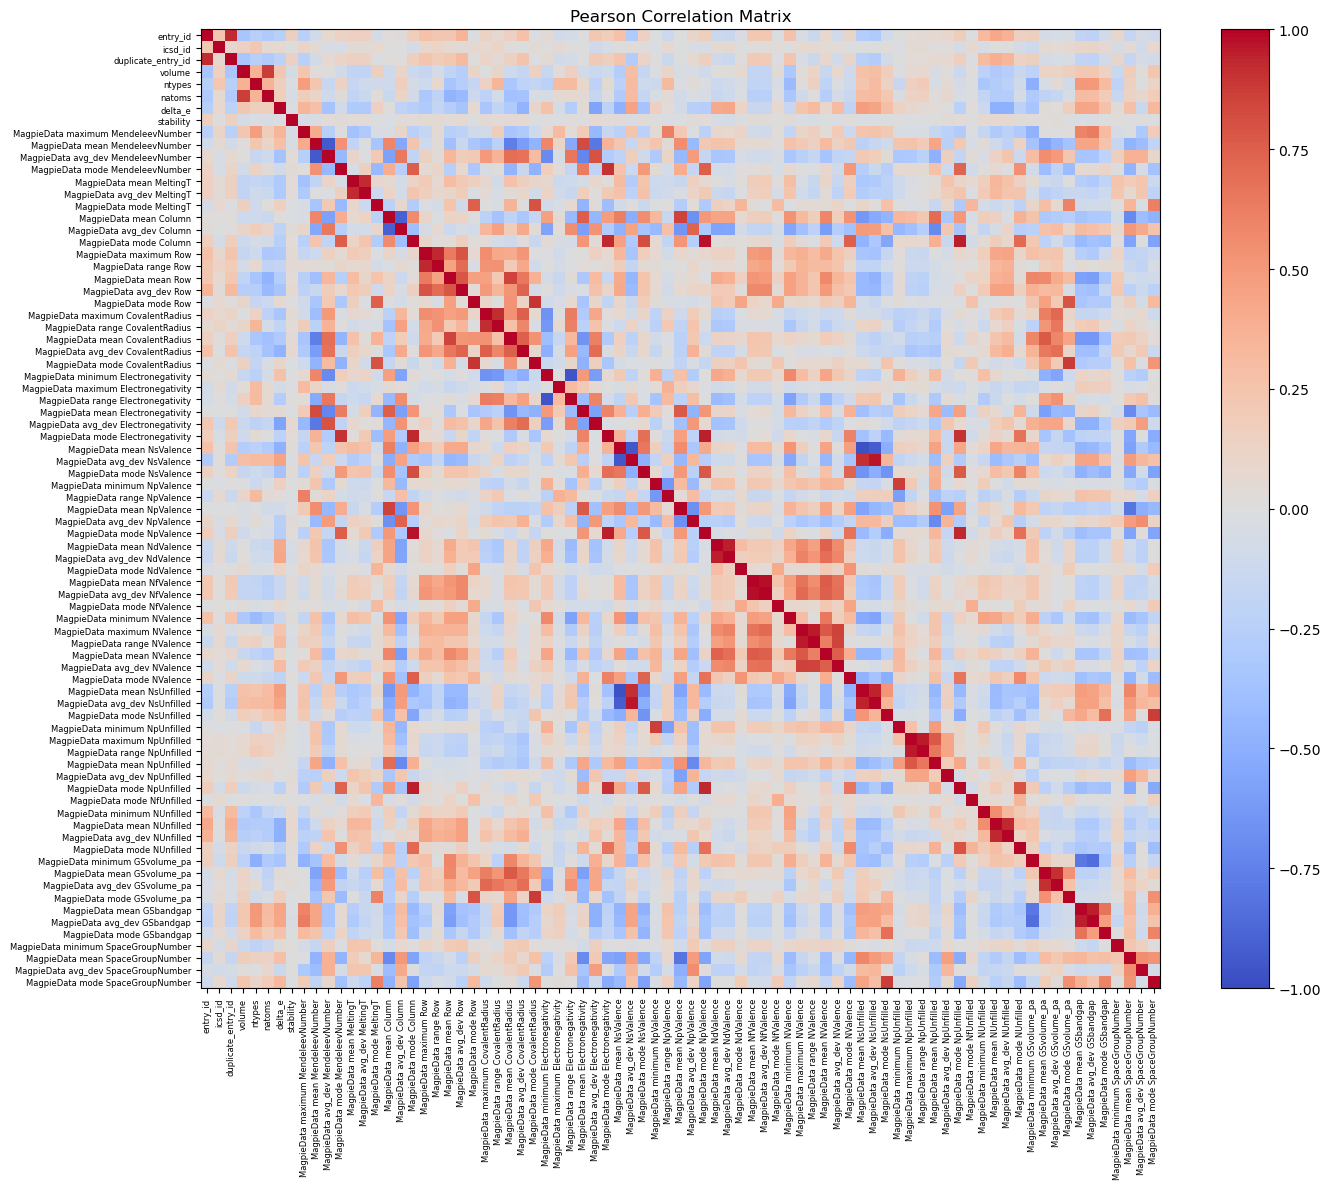

In [30]:
y = df_featurized['band_gap']  # type: ignore
X_all = df_featurized.drop(columns=['band_gap', 'composition']) # type: ignore

print("Number of features before cleaning:", X_all.shape[1])

# Keep ONLY numeric columns
X_all = X_all.select_dtypes(include=['number'])

# Identify columns with very small variance and drop them
small_var_cols = X_all.columns[X_all.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols)
X_all = X_all.drop(columns=small_var_cols)
corr_matrix = X_all.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all.shape[1])

# Remove highly correlated columns
threshold = 0.98 #SET IT TO 0.98, COULD SWITCH IT BACK TO 0.99 IF NEEDED
to_drop = set()
for col in corr_matrix.columns:
    high_corr = corr_matrix.index[(corr_matrix[col].abs() > threshold) & (corr_matrix.index != col)]
    to_drop.update(high_corr)
print("Columns to drop due to high correlation:", to_drop)
X = X_all.drop(columns=list(to_drop))
print("Number of features after removing highly correlated columns:", X.shape[1])

# For the remaining features, let's visualize the correlation matrix
corr_matrix = X.corr(method='pearson')

plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=6)
plt.tight_layout()
plt.show()

### scale and split train/test

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")



Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


### Dummy model for baseline prediction

In [32]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE (predicting band gap): {baseline_mae:.4f}")

Baseline MAE (predicting band gap): 1.3041


### **Hyperparameter optimization** Picking three values each for n_estimators, max_depth, max_features, min_samples_split, and min_sample_leaf, for a total of 243 models. Will select best combination of hyperparameters

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# SELECTION OF HYPERPARAMETERS - 3 values each, added min_samples_leaf
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", 0.5, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Generate all combinations (now 3*3*3*3*3 = 243 combinations)
param_combinations = list(product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["max_features"],
    param_grid["min_samples_split"],
    param_grid["min_samples_leaf"]
))

results = []

# Train each model
for (n_est, depth, max_feat, min_split, min_leaf) in tqdm(param_combinations, desc=f"Training {len(param_combinations)} RF models"):
    
    rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        max_features=max_feat,
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        random_state=17,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    results.append({
        "n_estimators": n_est,
        "max_depth": depth,
        "max_features": max_feat,
        "min_samples_split": min_split,
        "min_samples_leaf": min_leaf,
        "train_mae": train_mae,
        "val_mae": val_mae
    })

results_df = pd.DataFrame(results)

# Pick lowest validation MAE
best_row = results_df.loc[results_df["val_mae"].idxmin()]
print("Best Hyperparameters:")
print(best_row)

print("\nBest Validation MAE:", best_row["val_mae"])

# Show full table sorted by validation performance
display(results_df.sort_values("val_mae"))


Training 243 RF models:   0%|          | 0/243 [00:00<?, ?it/s]

Best Hyperparameters:
n_estimators              500
max_depth                20.0
max_features              0.5
min_samples_split           2
min_samples_leaf            1
train_mae            0.209979
val_mae              0.542003
Name: 225, dtype: object

Best Validation MAE: 0.5420029974701938


,n_estimators,max_depth,max_features,min_samples_split,min_samples_leaf,train_mae,val_mae
225,500,20.0,0.5,2,1,0.209979,0.542003
147,300,20.0,0.5,5,1,0.236659,0.542019
171,500,NaN,0.5,2,1,0.210185,0.542365
172,500,NaN,0.5,2,2,0.241927,0.542629
228,500,20.0,0.5,5,1,0.235776,0.542995
...,...,...,...,...,...,...,...
113,300,10.0,sqrt,5,4,0.479285,0.631648
33,100,10.0,sqrt,10,1,0.464706,0.632024
197,500,10.0,sqrt,10,4,0.488101,0.632656
35,100,10.0,sqrt,10,4,0.492676,0.633075


### **Recursive feature elimination**

RFE Progress:   0%|          | 0/15 [00:00<?, ?it/s]

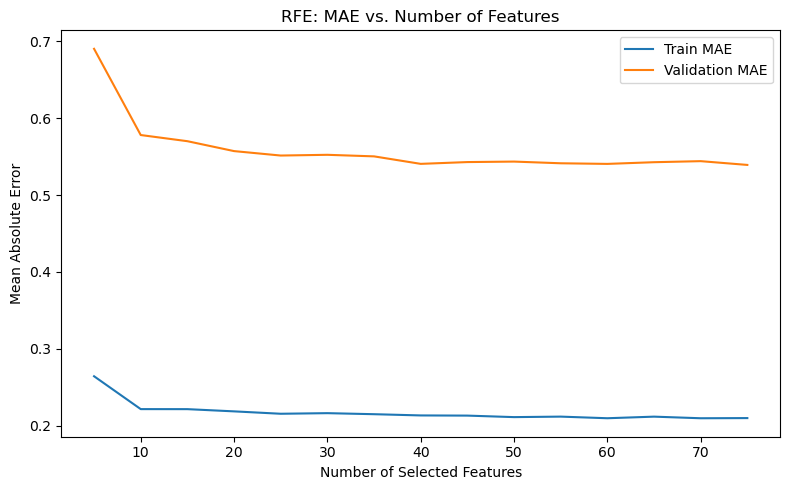

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

rf = RandomForestRegressor(n_estimators=500, max_depth=20, max_features=0.5, min_samples_split=2, min_samples_leaf=1, random_state=17, n_jobs=1)
n_features_list = list(range(5, X_val.shape[1]+1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=5)
    rfe.fit(X_train, y_train)
    selected_features_dict[n_features] = list(X.columns[rfe.support_])
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()

### **Final model evalutation**: only need ~15 features to relatively minimize MAE, but 40 features shows best MAE values

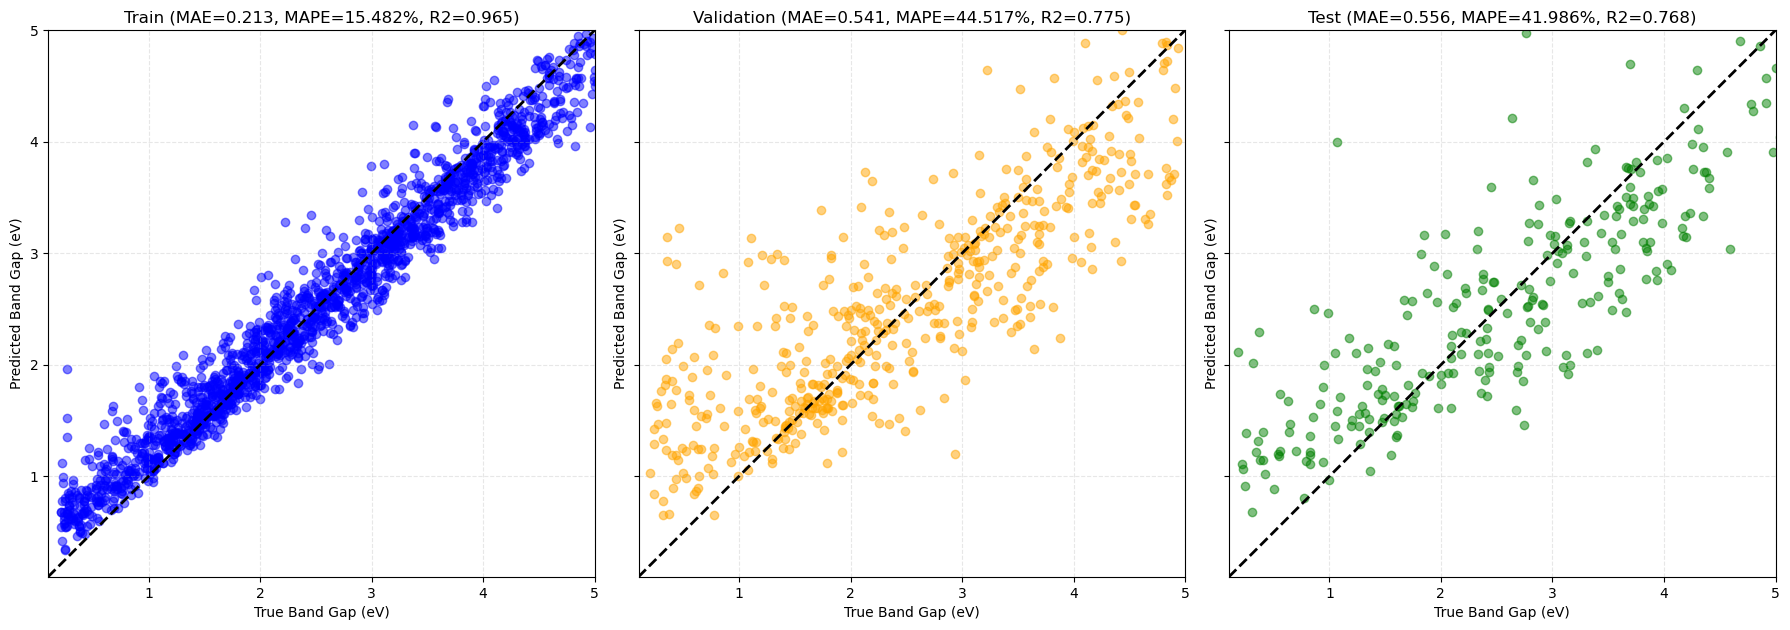

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error


final_features = selected_features_dict[40]
rf_final = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features=0.5,
    min_samples_split=2,
    random_state=17,
    n_jobs=1
    #min_samples_leaf default is 1 already
)

X_train_final = X_train[:, [X.columns.get_loc(f) for f in final_features]]
rf_final.fit(X_train_final, y_train)

# Predict
X_val_final = X_val[:, [X.columns.get_loc(f) for f in final_features]]
X_test_final = X_test[:, [X.columns.get_loc(f) for f in final_features]]

y_train_pred = rf_final.predict(X_train_final)
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

# Metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# --- Parity plots (0.1 to 5 range) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

min_val = 0.1
max_val = 5.0

# Train
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_title(f"Train (MAE={mae_train:.3f}, MAPE={mape_train:.3%}, R2={r2_train:.3f})")
axes[0].set_xlabel("True Band Gap (eV)")
axes[0].set_ylabel("Predicted Band Gap (eV)")
axes[0].set_aspect('equal', adjustable='box')
axes[0].grid(True, linestyle='--', alpha=0.3)

# Validation
axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_xlim(min_val, max_val)
axes[1].set_ylim(min_val, max_val)
axes[1].set_title(f"Validation (MAE={mae_val:.3f}, MAPE={mape_val:.3%}, R2={r2_val:.3f})")
axes[1].set_xlabel("True Band Gap (eV)")
axes[1].set_ylabel("Predicted Band Gap (eV)")
axes[1].set_aspect('equal', adjustable='box')
axes[1].grid(True, linestyle='--', alpha=0.3)

# Test
axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_xlim(min_val, max_val)
axes[2].set_ylim(min_val, max_val)
axes[2].set_title(f"Test (MAE={mae_test:.3f}, MAPE={mape_test:.3%}, R2={r2_test:.3f})")
axes[2].set_xlabel("True Band Gap (eV)")
axes[2].set_ylabel("Predicted Band Gap (eV)")
axes[2].set_aspect('equal', adjustable='box')
axes[2].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


# Attempt 2: Different featurizer

In [37]:
from dscribe.descriptors import CoulombMatrix
from ase.build import molecule
from ase.visualize import view
from dscribe.descriptors import EwaldSumMatrix
from pymatgen.io.ase import AseAtomsAdaptor

In [38]:
df_comp1 = df_oxides.copy()
df_comp1.head()

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,volume,ntypes,natoms,unit_cell,sites,band_gap,delta_e,stability,fit,calculation_label
0,VO,5578,5023,28681.0,4061871,5578.0,O1 V1,AB,NaCl,Fm-3m,21.6233,2,2,"[[2.211215, -2.211215, 0.0], [-2.211215, 0.0, ...","[O @ 0.5 0 0.5, V @ 0 0 0]",1.191,-2.259973,0.002871,standard,static
1,BeO,20737,5038,163820.0,4061895,20737.0,Be1 O1,AB,ZnS(cF8),F-43m,13.7009,2,2,"[[1.899211, -1.899211, 0.0], [-1.899211, 0.0, ...","[Be @ 0 0 0, O @ 0.75 0.5 0.25]",7.021,-2.960379,0.005831,standard,static
2,MgO,2577,5281,9863.0,4062087,2577.0,Mg1 O1,AB,NaCl,Fm-3m,18.5095,2,2,"[[2.099529, -2.099529, 0.0], [-2.099529, 0.0, ...","[Mg @ 0 0 0, O @ 0.5 0 0.5]",4.975,-2.945943,0.000346,standard,static
3,MnO,2578,5284,9864.0,4062090,2578.0,Mn1 O1,AB,NaCl,Fm-3m,22.1982,2,2,"[[2.230638, -2.230638, 0.0], [-2.230638, 0.0, ...","[Mn @ 0 0 0, O @ 0.5 0 0.5]",0.423,-2.036127,0.002118,standard,static
4,NiO,2580,5289,9866.0,4062093,8206.0,Ni1 O1,AB,NaCl,Fm-3m,18.1016,2,2,"[[2.083992, -2.083992, 0.0], [-2.083992, 0.0, ...","[Ni @ 0 0 0, O @ 0.5 0 0.5]",2.620,-1.239372,0.002141,standard,static


In [39]:
df_comp1.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,2835.000000,2.835000e+03,2469.000000,2.835000e+03,2834.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,55959.944621,5.279984e+05,121850.262454,4.330324e+06,59235.855328,190.248488,3.499471,14.500529,2.786638,-2.221272,0.110539
std,113227.655473,4.549565e+05,125565.627333,2.755716e+05,120341.665443,120.215884,0.733017,10.886771,1.518161,0.747234,1.044998
min,1605.000000,5.023000e+03,7.000000,4.061871e+06,1605.000000,13.700900,2.000000,2.000000,0.183000,-4.150927,0.000000
25%,6332.000000,1.450695e+05,30283.000000,4.090164e+06,6482.250000,109.740500,3.000000,8.000000,1.596000,-2.798503,0.000000
50%,15461.000000,4.811750e+05,75254.000000,4.225941e+06,15693.000000,165.406000,3.000000,12.000000,2.651000,-2.260385,0.004057
75%,23758.500000,8.489845e+05,167053.000000,4.504952e+06,23924.000000,243.377000,4.000000,18.000000,3.826000,-1.659173,0.044370
max,675524.000000,1.234533e+06,653737.000000,4.790301e+06,675524.000000,1623.180000,7.000000,175.000000,7.769000,0.224984,54.471736


### **Structural featurization**: OQMD does not have a 'structure' column like materials project, but it does have 'unit_cell' and 'sites'. From this, we can use Pymatgen to contruct a structure

In [40]:
from pymatgen.core import Lattice, Structure

def parse_site(site_str):
    # Example input: "O @ 0.5 0.5 0.5"
    element, _, coords_str = site_str.partition(" @ ")
    coords = list(map(float, coords_str.split()))
    return element, coords

def create_structure(row):
    lattice = Lattice(row['unit_cell'])
    
    species = []
    coords = []
    
    for site_str in row['sites']:
        el, crd = parse_site(site_str)
        species.append(el)
        coords.append(crd)
    
    struct = Structure(lattice, species, coords)  # coords are fractional by default
    return struct

# Apply to your dataframe
df_comp1['structure'] = df_comp1.apply(create_structure, axis=1)

# Then make a copy with all existing columns + 'structure'
df_structure = df_comp1.copy()

df_structure.head()

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,...,ntypes,natoms,unit_cell,sites,band_gap,delta_e,stability,fit,calculation_label,structure
0,VO,5578,5023,28681.0,4061871,5578.0,O1 V1,AB,NaCl,Fm-3m,...,2,2,"[[2.211215, -2.211215, 0.0], [-2.211215, 0.0, ...","[O @ 0.5 0 0.5, V @ 0 0 0]",1.191,-2.259973,0.002871,standard,static,"[[2.211215 0. 0. ] O, [0. 0. 0.] V]"
1,BeO,20737,5038,163820.0,4061895,20737.0,Be1 O1,AB,ZnS(cF8),F-43m,...,2,2,"[[1.899211, -1.899211, 0.0], [-1.899211, 0.0, ...","[Be @ 0 0 0, O @ 0.75 0.5 0.25]",7.021,-2.960379,0.005831,standard,static,"[[0. 0. 0.] Be, [ 0.9496055 -0.9496055 -0.9496..."
2,MgO,2577,5281,9863.0,4062087,2577.0,Mg1 O1,AB,NaCl,Fm-3m,...,2,2,"[[2.099529, -2.099529, 0.0], [-2.099529, 0.0, ...","[Mg @ 0 0 0, O @ 0.5 0 0.5]",4.975,-2.945943,0.000346,standard,static,"[[0. 0. 0.] Mg, [2.099529 0. 0. ] O]"
3,MnO,2578,5284,9864.0,4062090,2578.0,Mn1 O1,AB,NaCl,Fm-3m,...,2,2,"[[2.230638, -2.230638, 0.0], [-2.230638, 0.0, ...","[Mn @ 0 0 0, O @ 0.5 0 0.5]",0.423,-2.036127,0.002118,standard,static,"[[0. 0. 0.] Mn, [2.230638 0. 0. ] O]"
4,NiO,2580,5289,9866.0,4062093,8206.0,Ni1 O1,AB,NaCl,Fm-3m,...,2,2,"[[2.083992, -2.083992, 0.0], [-2.083992, 0.0, ...","[Ni @ 0 0 0, O @ 0.5 0 0.5]",2.620,-1.239372,0.002141,standard,static,"[[0. 0. 0.] Ni, [2.083992 0. 0. ] O]"


In [41]:
df_structure.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,2835.000000,2.835000e+03,2469.000000,2.835000e+03,2834.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,55959.944621,5.279984e+05,121850.262454,4.330324e+06,59235.855328,190.248488,3.499471,14.500529,2.786638,-2.221272,0.110539
std,113227.655473,4.549565e+05,125565.627333,2.755716e+05,120341.665443,120.215884,0.733017,10.886771,1.518161,0.747234,1.044998
min,1605.000000,5.023000e+03,7.000000,4.061871e+06,1605.000000,13.700900,2.000000,2.000000,0.183000,-4.150927,0.000000
25%,6332.000000,1.450695e+05,30283.000000,4.090164e+06,6482.250000,109.740500,3.000000,8.000000,1.596000,-2.798503,0.000000
50%,15461.000000,4.811750e+05,75254.000000,4.225941e+06,15693.000000,165.406000,3.000000,12.000000,2.651000,-2.260385,0.004057
75%,23758.500000,8.489845e+05,167053.000000,4.504952e+06,23924.000000,243.377000,4.000000,18.000000,3.826000,-1.659173,0.044370
max,675524.000000,1.234533e+06,653737.000000,4.790301e+06,675524.000000,1623.180000,7.000000,175.000000,7.769000,0.224984,54.471736


### Featurize using Ewald Sum Matrix

In [42]:
from dscribe.descriptors import EwaldSumMatrix
from pymatgen.io.ase import AseAtomsAdaptor
import numpy as np

# Determine the maximum number of atoms across all structures in the dataset
n_max = 0
for mat in df_structure['structure']:
    if len(mat) > n_max :
        n_max = len(mat)
print(n_max)

ews = EwaldSumMatrix(n_atoms_max=n_max, permutation="eigenspectrum")

ase_structures = [AseAtomsAdaptor.get_atoms(struc) for struc in df_structure['structure']]
ews_matrices = np.array(ews.create(ase_structures))

175


In [43]:
ews_columns = [f'ews_{i}' for i in range(ews_matrices.shape[1])]
df_featurized_ews = df_structure.copy() #NEED TO COPY DF_STRUCTURE TO AVOID OVERWRITING
df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
df_featurized_ews.head()

/var/folders/qm/5sjb9c6x42qfnfbqt3vs1x6m0000gn/T/ipykernel_1291/3198656235.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
/var/folders/qm/5sjb9c6x42qfnfbqt3vs1x6m0000gn/T/ipykernel_1291/3198656235.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
/var/folders/qm/5sjb9c6x42qfnfbqt3vs1x6m0000gn/T/ipykernel_1291/3198656235.py:3: PerformanceWarnin

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,...,ews_165,ews_166,ews_167,ews_168,ews_169,ews_170,ews_171,ews_172,ews_173,ews_174
0,VO,5578,5023,28681.0,4061871,5578.0,O1 V1,AB,NaCl,Fm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BeO,20737,5038,163820.0,4061895,20737.0,Be1 O1,AB,ZnS(cF8),F-43m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MgO,2577,5281,9863.0,4062087,2577.0,Mg1 O1,AB,NaCl,Fm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MnO,2578,5284,9864.0,4062090,2578.0,Mn1 O1,AB,NaCl,Fm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NiO,2580,5289,9866.0,4062093,8206.0,Ni1 O1,AB,NaCl,Fm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Number of numeric features before cleaning: 185
Columns with very small variance: []
Number of features after removing small variance columns: 185
Columns to drop due to high correlation: {'ews_77', 'ews_156', 'ews_91', 'ews_149', 'ews_93', 'ews_143', 'ews_135', 'ews_174', 'ews_169', 'ews_129', 'ews_139', 'ews_100', 'ews_102', 'ews_123', 'ews_158', 'ews_76', 'ews_89', 'ews_108', 'ews_119', 'ews_142', 'ews_116', 'ews_140', 'ews_105', 'ews_159', 'ews_134', 'ews_78', 'ews_101', 'ews_160', 'ews_168', 'ews_150', 'ews_117', 'ews_170', 'ews_146', 'ews_111', 'ews_164', 'ews_90', 'ews_92', 'ews_112', 'ews_155', 'ews_167', 'ews_165', 'ews_88', 'ews_85', 'ews_153', 'ews_95', 'ews_122', 'ews_128', 'ews_157', 'ews_121', 'ews_162', 'ews_171', 'ews_154', 'ews_79', 'ews_81', 'ews_94', 'ews_104', 'ews_106', 'ews_118', 'ews_96', 'ews_110', 'ews_98', 'ews_86', 'ews_115', 'ews_83', 'ews_87', 'ews_107', 'ews_120', 'ews_141', 'ews_82', 'ews_131', 'ews_133', 'ews_126', 'ews_161', 'ews_80', 'ews_145', 'ews_13

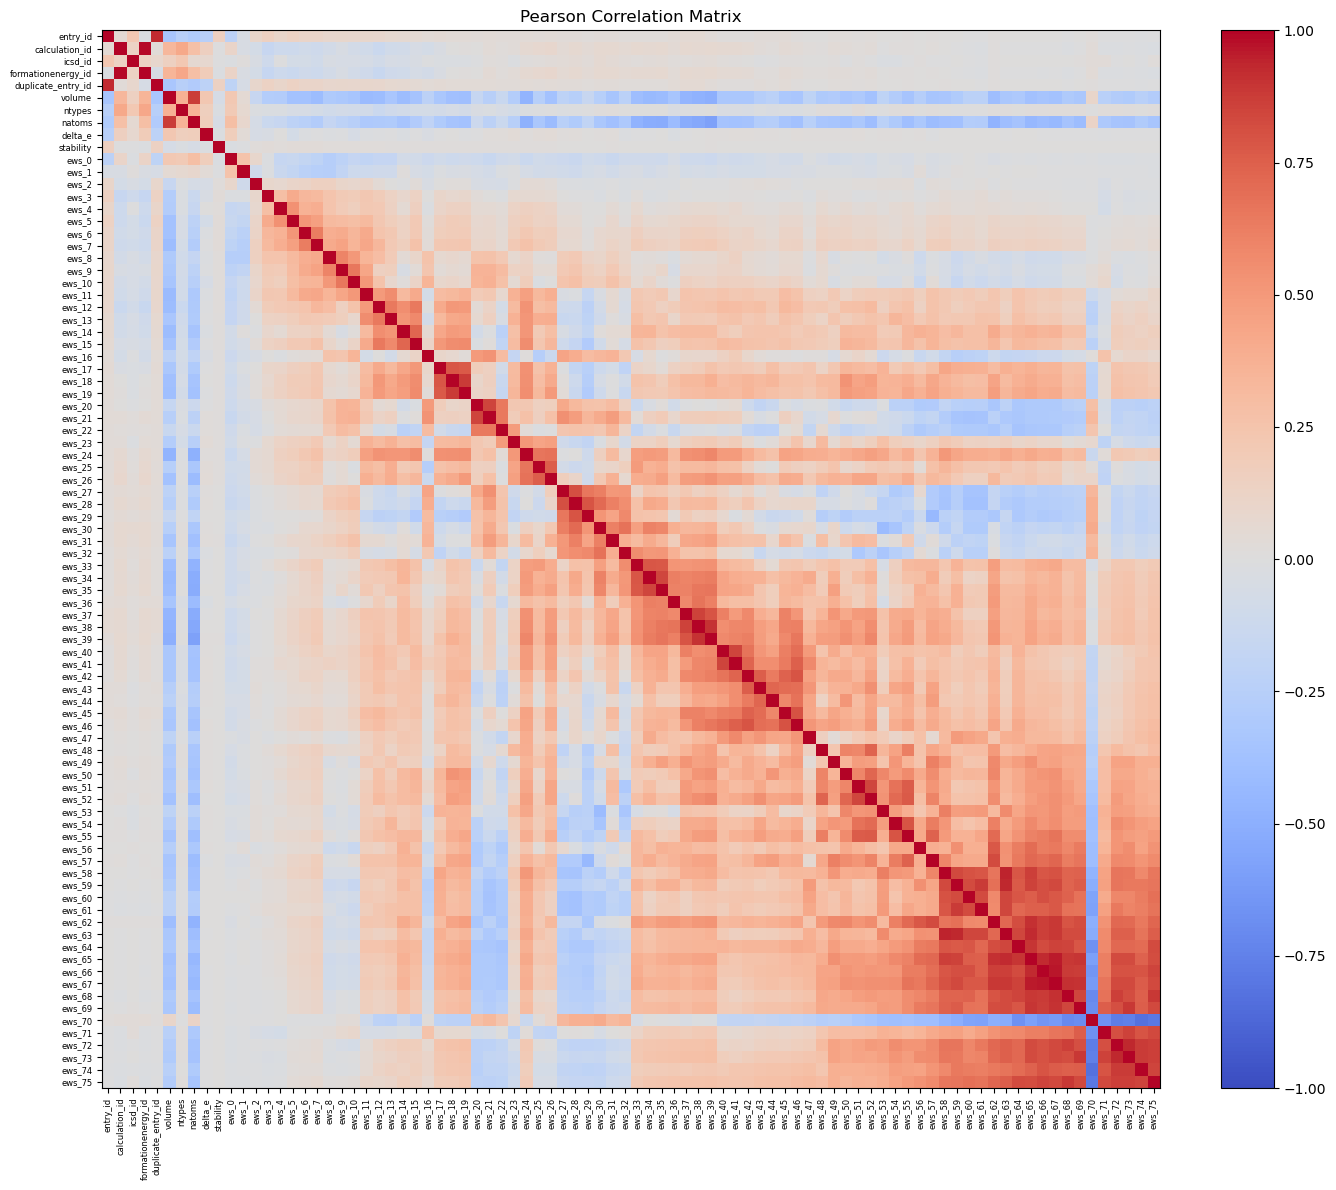

In [44]:
import matplotlib.pyplot as plt

y = df_featurized_ews['band_gap']
X_all_struc = df_featurized_ews.drop(columns=['band_gap', 'structure'])

# Keep only numeric columns
X_all_struc = X_all_struc.select_dtypes(include=[float, int])
print("Number of numeric features before cleaning:", X_all_struc.shape[1])

# Identify columns with very small variance and drop them
small_var_cols_struc = X_all_struc.columns[X_all_struc.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols_struc)
X_all_struc = X_all_struc.drop(columns=small_var_cols_struc)

# Compute correlation matrix
corr_matrix_struc = X_all_struc.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all_struc.shape[1])

# Remove highly correlated columns
threshold = 0.99 
to_drop_struc = set()
for col in corr_matrix_struc.columns:
    high_corr_struc = corr_matrix_struc.index[
        (corr_matrix_struc[col].abs() > threshold) & (corr_matrix_struc.index != col)
    ]
    to_drop_struc.update(high_corr_struc)
print("Columns to drop due to high correlation:", to_drop_struc)
X_struc = X_all_struc.drop(columns=list(to_drop_struc))
print("Number of features after removing highly correlated columns:", X_struc.shape[1])

# Plot correlation matrix
corr_matrix_struc = X_struc.corr(method='pearson')
plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix_struc, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], fontsize=6)
plt.tight_layout()
plt.show()


In [45]:
# SPLIT INTO TRAIN VALIDATION AND TEST
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_struc)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")

Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


In [46]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE (predicting density): {baseline_mae:.4f} ")

Baseline MAE (predicting density): 1.3041 


### Redo hyperparameter optimization for new featurized dataset

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# SELECTION OF HYPERPARAMETERS - 3 values each, added min_samples_leaf
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", 0.5, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Generate all combinations (now 3*3*3*3*3 = 243 combinations)
param_combinations = list(product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["max_features"],
    param_grid["min_samples_split"],
    param_grid["min_samples_leaf"]
))

results = []

# Train each model
for (n_est, depth, max_feat, min_split, min_leaf) in tqdm(param_combinations, desc=f"Training {len(param_combinations)} RF models"):
    
    rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        max_features=max_feat,
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        random_state=17,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    results.append({
        "n_estimators": n_est,
        "max_depth": depth,
        "max_features": max_feat,
        "min_samples_split": min_split,
        "min_samples_leaf": min_leaf,
        "train_mae": train_mae,
        "val_mae": val_mae
    })

results_df = pd.DataFrame(results)

# Pick lowest validation MAE
best_row = results_df.loc[results_df["val_mae"].idxmin()]
print("Best Hyperparameters:")
print(best_row)

print("\nBest Validation MAE:", best_row["val_mae"])

# Show full table sorted by validation performance
display(results_df.sort_values("val_mae"))


Training 243 RF models:   0%|          | 0/243 [00:00<?, ?it/s]

Best Hyperparameters:
n_estimators              300
max_depth                 NaN
max_features             None
min_samples_split           2
min_samples_leaf            2
train_mae            0.293097
val_mae              0.730813
Name: 100, dtype: object

Best Validation MAE: 0.730813075009777


,n_estimators,max_depth,max_features,min_samples_split,min_samples_leaf,train_mae,val_mae
100,300,NaN,None,2,2,0.293097,0.730813
234,500,20.0,None,2,1,0.258314,0.731021
154,300,20.0,None,2,2,0.293185,0.731339
180,500,NaN,None,2,1,0.257756,0.731390
102,300,NaN,None,5,1,0.287827,0.731602
...,...,...,...,...,...,...,...
110,300,10.0,sqrt,2,4,0.667759,0.882188
113,300,10.0,sqrt,5,4,0.667759,0.882188
116,300,10.0,sqrt,10,4,0.677963,0.883745
34,100,10.0,sqrt,10,2,0.659180,0.885364


In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

### Going to use model #234 above, best combination of train and validation MAE

RFE Progress:   0%|          | 0/17 [00:00<?, ?it/s]

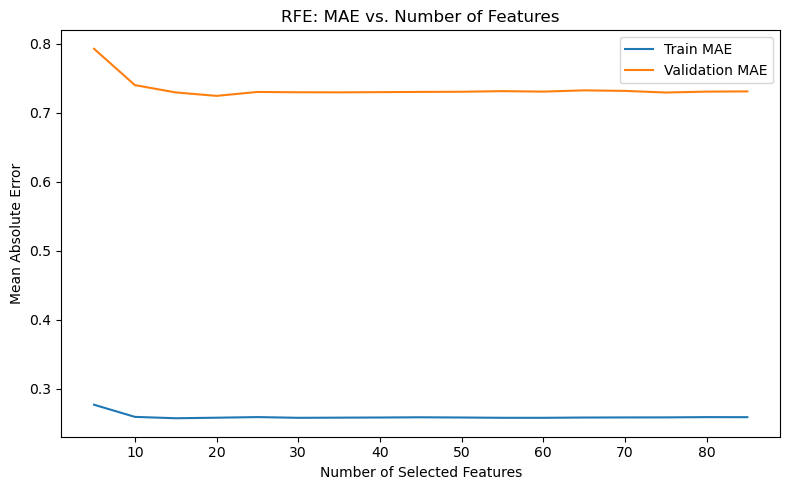

In [49]:
# Use your already scaled and split data:
# X_train, X_val, y_train, y_val

# Because X_train and X_val are numpy arrays (scaled), 
# you need to keep track of feature names separately
feature_names = X_struc.columns  # from your previous cleaning step

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features=None,
    min_samples_split=2,
    random_state=17,
    n_jobs=1
)

n_features_list = list(range(5, X_val.shape[1]+1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=5)
    rfe.fit(X_train, y_train)
    
    selected_features = feature_names[rfe.support_].tolist()
    selected_features_dict[n_features] = selected_features
    
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()


### Only ~20 features needed

Train MAE: 0.25838104087510555 MAPE: 0.18657172775294822 R²: 0.9492119769890197
Val   MAE: 0.7246384762445205 MAPE: 0.5803383501873338 R²: 0.6039458220420326
Test  MAE: 0.6990785153044793 MAPE: 0.5201863705778188 R²: 0.6108452461006466


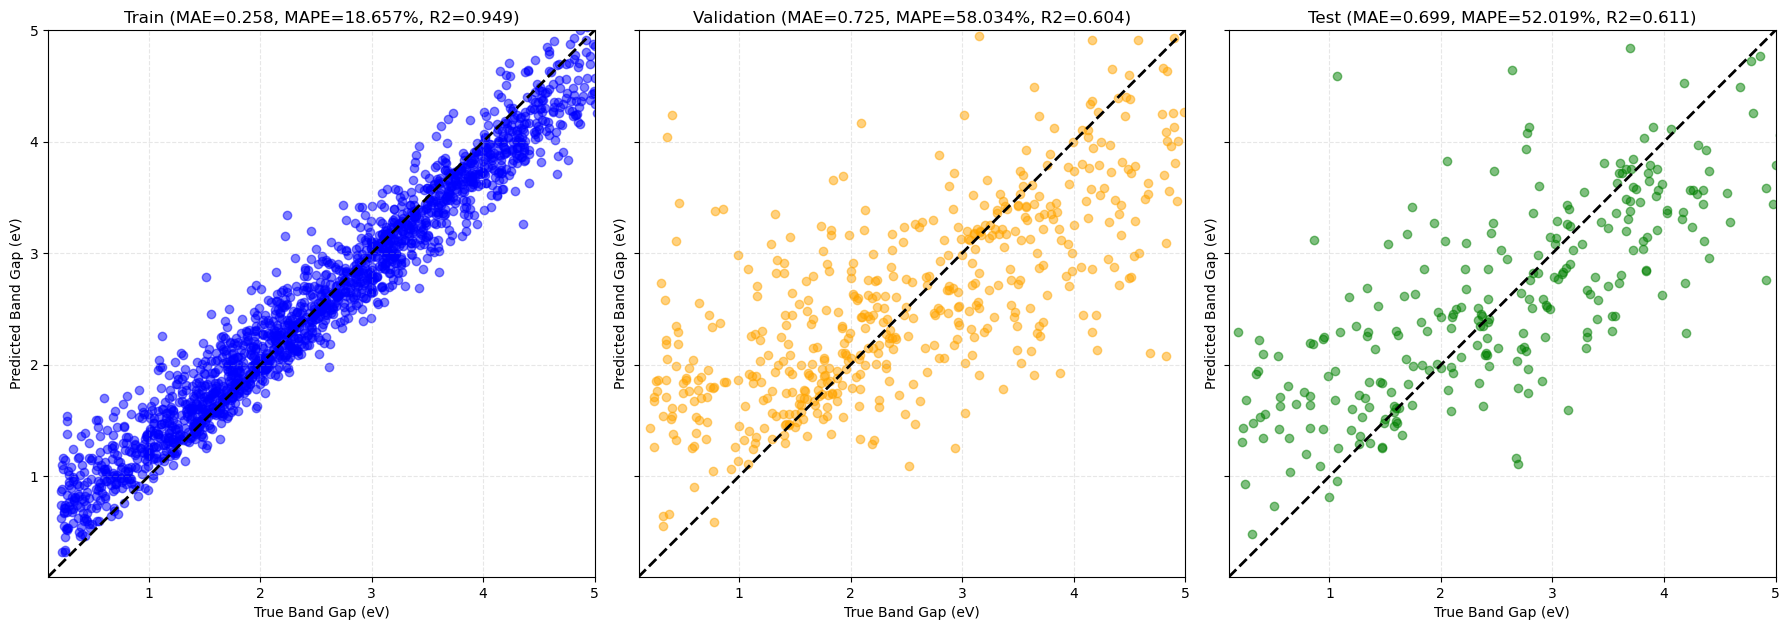

In [51]:
from sklearn.metrics import r2_score, mean_absolute_error

final_features = selected_features_dict[20]   # <-- USE 20 FEATURES

# BUILD FINAL MODEL
rf_final = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features=None,
    min_samples_split=2,
    random_state=17,
    n_jobs=1
)

# Extract feature columns from scaled numpy arrays
feature_idx = [feature_names.get_loc(f) for f in final_features]

X_train_final = X_train[:, feature_idx]
X_val_final   = X_val[:, feature_idx]
X_test_final  = X_test[:, feature_idx]

#FIT MODEL
rf_final.fit(X_train_final, y_train)

#PREDICTIONS
y_train_pred = rf_final.predict(X_train_final)
y_val_pred   = rf_final.predict(X_val_final)
y_test_pred  = rf_final.predict(X_test_final)

# METRICS
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val   = mean_absolute_error(y_val, y_val_pred)
mae_test  = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val   = r2_score(y_val, y_val_pred)
r2_test  = r2_score(y_test, y_test_pred)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print("Train MAE:", mae_train, "MAPE:", mape_train, "R²:", r2_train)
print("Val   MAE:", mae_val,   "MAPE:", mape_val,   "R²:", r2_val)
print("Test  MAE:", mae_test,  "MAPE:", mape_test,  "R²:", r2_test)
# PARITY PLOTS
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

min_val = 0.1
max_val = 5.0

# TRAINING, VALIDATION, TEST
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_title(f"Train (MAE={mae_train:.3f}, MAPE={mape_train:.3%}, R2={r2_train:.3f})")
axes[0].set_xlabel("True Band Gap (eV)")
axes[0].set_ylabel("Predicted Band Gap (eV)")
axes[0].set_aspect('equal', adjustable='box')
axes[0].grid(True, linestyle='--', alpha=0.3)

axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_xlim(min_val, max_val)
axes[1].set_ylim(min_val, max_val)
axes[1].set_title(f"Validation (MAE={mae_val:.3f}, MAPE={mape_val:.3%}, R2={r2_val:.3f})")
axes[1].set_xlabel("True Band Gap (eV)")
axes[1].set_ylabel("Predicted Band Gap (eV)")
axes[1].set_aspect('equal', adjustable='box')
axes[1].grid(True, linestyle='--', alpha=0.3)

axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_xlim(min_val, max_val)
axes[2].set_ylim(min_val, max_val)
axes[2].set_title(f"Test (MAE={mae_test:.3f}, MAPE={mape_test:.3%}, R2={r2_test:.3f})")
axes[2].set_xlabel("True Band Gap (eV)")
axes[2].set_ylabel("Predicted Band Gap (eV)")
axes[2].set_aspect('equal', adjustable='box')
axes[2].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
